# The Impact of Marketing carriers on Flight Delay Patterns

# Name: Robin Nguyen

**This study analyzes the impact of the collabaration of airlines in the U.S. on flight delay  patterns. By leveraging time series analysis, the research aims to uncover temporal and spatial trends, identify critical factors contributing to delays and evaluate how specific geographic divisions influence these patterns.**

### Import libraries

In [ ]:
!pip install statsmodels
# Core Libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical computations
import os
import glob
import re
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Advanced visualization
from matplotlib.ticker import NullFormatter, FuncFormatter  # Formatting

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ignore warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 17.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. DATA PROCESSING

## A. Preping Data


In [ ]:
# List CSV files
csv_files = [
   "/content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_1.csv",
   "/content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_2.csv",
   "/content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_3.csv"
]

# Output file path
output_file ="/content/drive/My Drive/plane_collab_project/data/combined_data/quarter_1.csv"

# Remove the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# Define chunk size
chunk_size = 100_000

# Process files in chunks
for file in csv_files:
    print(f"Processing file: {file}")
    for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
        # Append each chunk to the output file
        chunk.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)

print(f"All files combined and saved to {output_file}")

Processing file: /content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_1.csv
Processing file: /content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_2.csv
Processing file: /content/drive/My Drive/plane_collab_project/data/uncombined_data/T_ONTIME_MARKETING_3.csv
All files combined and saved to /content/drive/My Drive/plane_collab_project/data/combined_data/quarter_1.csv


## 2. Clean Data & Explainatory Data Analysis (EDA)

### A. Testing data

In [ ]:
# Import df
file_path = "/content/drive/My Drive/plane_collab_project/data/combined_data/quarter_1.csv"
test_df= pd.read_csv(file_path)

In [ ]:
# Create a copy
testing_df = test_df.copy()

In [ ]:
# View columns
testing_df.columns

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'MKT_UNIQUE_CARRIER', 'BRANDED_CODE_SHARE', 'MKT_CARRIER_AIRLINE_ID',
       'MKT_CARRIER', 'MKT_CARRIER_FL_NUM', 'SCH_OP_UNIQUE_CARRIER',
       'SCH_OP_CARRIER_AIRLINE_ID', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'ORIGIN',
       'ORIGIN_STATE_FIPS', 'DEST_AIRPORT_ID', 'DEST', 'DEST_STATE_FIPS',
       'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ARR_DEL15', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [ ]:
# Drop unnesscary columns
testing_df = testing_df.drop(['FL_DATE'], axis=1)

In [ ]:
# Fill N/A rows
columns_to_fill = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
testing_df[columns_to_fill] = testing_df[columns_to_fill].fillna(0)

In [ ]:
# View df
testing_df.head(5)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,MKT_CARRIER_FL_NUM,SCH_OP_UNIQUE_CARRIER,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2025,1,1,3,AA,AA,19805,AA,1,NaN,...,377.0,345.0,1.0,2475.0,10,0.0,0.0,0.0,0.0,0.0
1,2025,1,1,3,AA,AA,19805,AA,10,NaN,...,290.0,274.0,1.0,2475.0,10,0.0,0.0,0.0,0.0,0.0
2,2025,1,1,3,AA,AA,19805,AA,1002,NaN,...,125.0,91.0,1.0,708.0,3,20.0,0.0,0.0,0.0,0.0
3,2025,1,1,3,AA,AA,19805,AA,1004,NaN,...,331.0,306.0,1.0,2176.0,9,0.0,0.0,0.0,0.0,0.0
4,2025,1,1,3,AA,AA,19805,AA,1005,NaN,...,286.0,212.0,1.0,1440.0,6,0.0,0.0,44.0,0.0,0.0


In [ ]:
# View df
testing_df.tail(5)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,BRANDED_CODE_SHARE,MKT_CARRIER_AIRLINE_ID,MKT_CARRIER,MKT_CARRIER_FL_NUM,SCH_OP_UNIQUE_CARRIER,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1823517,2025,3,31,1,WN,WN,19393,WN,995,NaN,...,104.0,80.0,1.0,601.0,3,0.0,0.0,0.0,0.0,0.0
1823518,2025,3,31,1,WN,WN,19393,WN,996,NaN,...,89.0,74.0,1.0,547.0,3,0.0,0.0,0.0,0.0,0.0
1823519,2025,3,31,1,WN,WN,19393,WN,997,NaN,...,70.0,60.0,1.0,494.0,2,0.0,0.0,0.0,0.0,0.0
1823520,2025,3,31,1,WN,WN,19393,WN,998,NaN,...,182.0,169.0,1.0,1481.0,6,0.0,0.0,0.0,0.0,0.0
1823521,2025,3,31,1,WN,WN,19393,WN,999,NaN,...,245.0,225.0,1.0,1491.0,6,0.0,0.0,0.0,0.0,0.0


In [ ]:
# View shape of df
def check_df(df: object, head: object = 5) -> object:
    print("\nShape")
    print(df.shape)
    print("\nTypes")
    print(df.dtypes)
    print("\nNANs")
    print(df.isnull().sum())
    print("\nInfo")
    print(df.info())

# Check shape, datatypes, and na of df
check_df(testing_df)


Shape
(1823522, 36)

Types
YEAR                           int64
MONTH                          int64
DAY_OF_MONTH                   int64
DAY_OF_WEEK                    int64
MKT_UNIQUE_CARRIER            object
BRANDED_CODE_SHARE            object
MKT_CARRIER_AIRLINE_ID         int64
MKT_CARRIER                   object
MKT_CARRIER_FL_NUM             int64
SCH_OP_UNIQUE_CARRIER         object
SCH_OP_CARRIER_AIRLINE_ID    float64
OP_UNIQUE_CARRIER             object
OP_CARRIER_AIRLINE_ID          int64
ORIGIN_AIRPORT_ID              int64
ORIGIN                        object
ORIGIN_STATE_FIPS              int64
DEST_AIRPORT_ID                int64
DEST                          object
DEST_STATE_FIPS                int64
DEP_DELAY                    float64
DEP_DELAY_NEW                float64
DEP_DEL15                    float64
ARR_DELAY                    float64
ARR_DELAY_NEW                float64
ARR_DEL15                    float64
CRS_ELAPSED_TIME             float64
ACTUAL_ELA

In [ ]:
# Filter for rows where BRANDED_CODE_SHARE ends with '_CODESHARE'
codeshare_flights = testing_df[testing_df['BRANDED_CODE_SHARE'].str.endswith('_CODESHARE')]

# Count the occurrences of each codeshare brand
codeshare_counts = codeshare_flights['BRANDED_CODE_SHARE'].value_counts()

# Display the counts
print("Number of flights for each Codeshare Brand:")
print(codeshare_counts)

# Calculate total number of codeshare flights
total_codeshares = codeshare_counts.sum()
print(f"\nTotal number of codeshare flights: {total_codeshares}")

Number of flights for each Codeshare Brand:
BRANDED_CODE_SHARE
AA_CODESHARE    243372
UA_CODESHARE    158933
DL_CODESHARE    141211
AS_CODESHARE     40502
Name: count, dtype: int64

Total number of codeshare flights: 584018


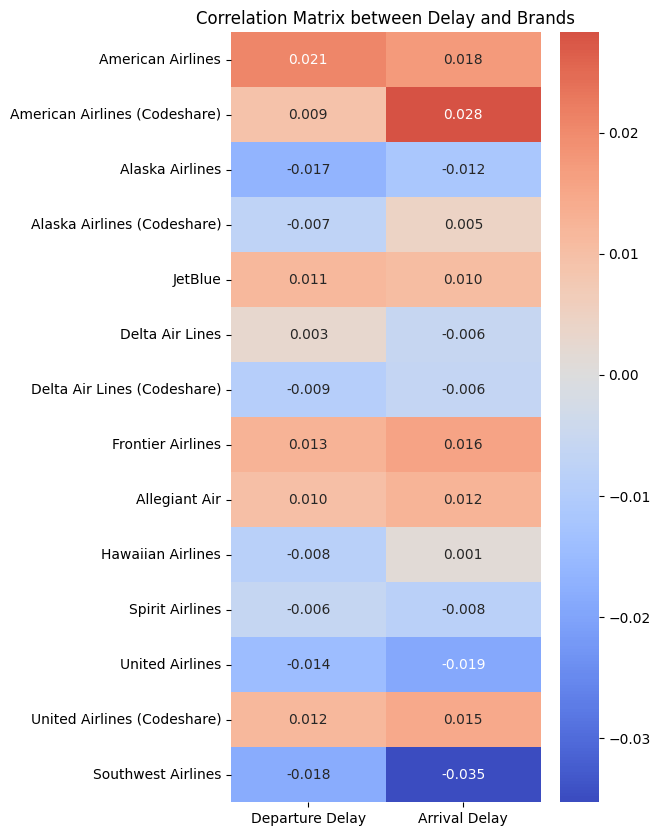

In [ ]:
# Create dummy variables for BRANDED_CODE_SHARE to calculate correlation
# This converts categories like 'AA', 'UA' into numeric columns
branded_dummies = pd.get_dummies(testing_df['BRANDED_CODE_SHARE'], prefix='BRAND')



# Select delay columns
delay_cols = testing_df[['DEP_DELAY', 'ARR_DELAY']]

# Concatenate delays with the new dummy variables
analysis_df = pd.concat([delay_cols, branded_dummies], axis=1)

# Calculate correlation between delays and the specific brands
# We filter the correlation matrix to only show the relevant rows and columns
# Transpose the matrix to list brands vertically
brand_delay_corr = analysis_df.corr().loc[['DEP_DELAY', 'ARR_DELAY'], branded_dummies.columns].T

# Rename columns for better readability
brand_delay_corr.columns = ['Departure Delay', 'Arrival Delay']

# Mapping dictionary for renaming
name_mapping = {
    'BRAND_AA': 'American Airlines',
    'BRAND_AA_CODESHARE': 'American Airlines (Codeshare)',
    'BRAND_AS': 'Alaska Airlines',
    'BRAND_AS_CODESHARE': 'Alaska Airlines (Codeshare)',
    'BRAND_B6': 'JetBlue',
    'BRAND_DL': 'Delta Air Lines',
    'BRAND_DL_CODESHARE': 'Delta Air Lines (Codeshare)',
    'BRAND_F9': 'Frontier Airlines',
    'BRAND_G4': 'Allegiant Air',
    'BRAND_HA': 'Hawaiian Airlines',
    'BRAND_NK': 'Spirit Airlines',
    'BRAND_UA': 'United Airlines',
    'BRAND_UA_CODESHARE': 'United Airlines (Codeshare)',
    'BRAND_WN': 'Southwest Airlines'
}

# Rename the index
brand_delay_corr.index = brand_delay_corr.index.map(lambda x: name_mapping.get(x, x))


# Plot the correlation heatmap
plt.figure(figsize=(5, 10))
sns.heatmap(brand_delay_corr, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix between Delay and Brands')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [38]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

Root Mean Squared Error (RMSE): 14.90
R^2 Score: 0.9322


## 3. Multiple Linear Regression Analysis

Here we build a more comprehensive model including:
*   **Departure Delay & Distance** (Numerical)
*   **Marketing Carrier** (Categorical)
*   **Month & Day of Week** (Categorical - to capture seasonality)

In [40]:
# Prepare data for Multiple Linear Regression

# Drop rows where target or predictors are missing
reg_df = testing_df.dropna(subset=['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']).copy()

# Create dummy variables for Categorical features
# drop_first=True avoids multicollinearity
carrier_dummies = pd.get_dummies(reg_df['BRANDED_CODE_SHARE'], prefix='CARRIER', drop_first=True)
month_dummies = pd.get_dummies(reg_df['MONTH'], prefix='MONTH', drop_first=True)
day_dummies = pd.get_dummies(reg_df['DAY_OF_WEEK'], prefix='DAY', drop_first=True)

# Define Features (X) and Target (y)
# Concatenate all features: Numerical + Carriers + Time features
X = pd.concat([reg_df[['DEP_DELAY', 'DISTANCE']], carrier_dummies, month_dummies, day_dummies], axis=1)
y = reg_df['ARR_DELAY']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data prepared with {X.shape[1]} features.")
print("Features included (First 10):", list(X.columns)[:10])

Data prepared with 23 features.
Features included (First 10): ['DEP_DELAY', 'DISTANCE', 'CARRIER_AA_CODESHARE', 'CARRIER_AS', 'CARRIER_AS_CODESHARE', 'CARRIER_B6', 'CARRIER_DL', 'CARRIER_DL_CODESHARE', 'CARRIER_F9', 'CARRIER_G4']


In [41]:
# Train the Multiple Linear Regression Model
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Make predictions
y_pred_multi = multi_model.predict(X_test)

# Evaluate
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

print(f"Root Mean Squared Error (RMSE): {rmse_multi:.2f}")
print(f"R^2 Score: {r2_multi:.4f}")

Root Mean Squared Error (RMSE): 14.89
R^2 Score: 0.9324


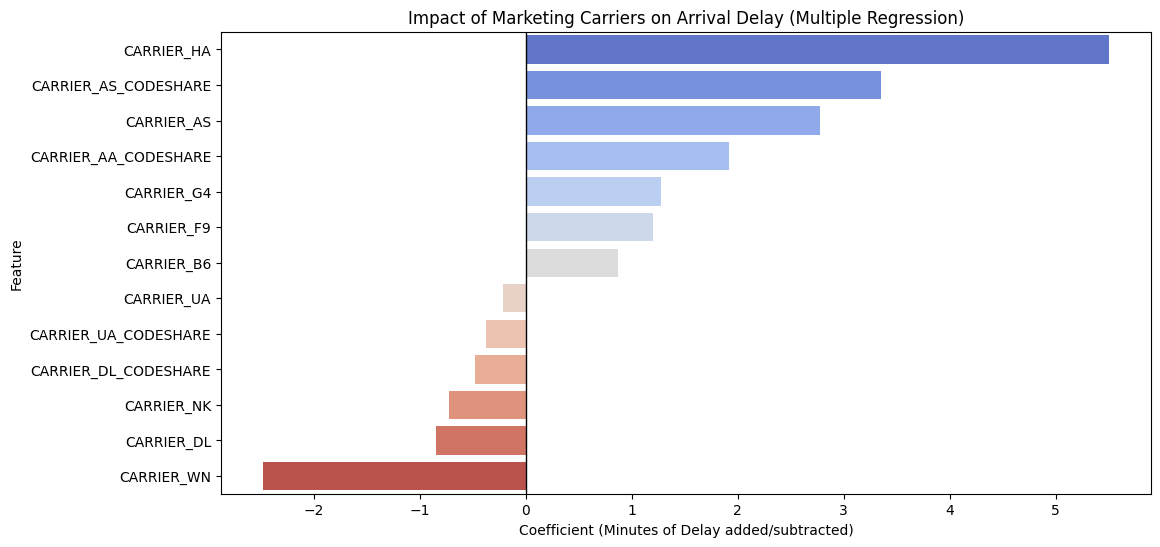

In [42]:
# Visualize Coefficients to compare impacts
coef_df_multi = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': multi_model.coef_
})

# Filter for Carriers to see their specific impact relative to the baseline
carrier_coefs_multi = coef_df_multi[coef_df_multi['Feature'].str.contains('CARRIER')].sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=carrier_coefs_multi, palette='coolwarm')
plt.title('Impact of Marketing Carriers on Arrival Delay (Multiple Regression)')
plt.xlabel('Coefficient (Minutes of Delay added/subtracted)')
plt.axvline(0, color='black', linewidth=1)
plt.show()

In [ ]:
# Group by Marketing Carrier and Operating Carrier to see specific collaborations
collaboration_counts = codeshare_flights.groupby(['MKT_UNIQUE_CARRIER', 'OP_UNIQUE_CARRIER']).size().reset_index(name='Flight_Count')

# Sort by Flight Count in descending order
top_collaborations = collaboration_counts.sort_values(by='Flight_Count', ascending=False)

print("Top Airline Collaborations (Marketing -> Operating):")
display(top_collaborations.head(10))

# Also check which Operating Carrier does the most codeshare work overall
top_operating_partners = codeshare_flights['OP_UNIQUE_CARRIER'].value_counts().reset_index()
top_operating_partners.columns = ['Operating_Carrier', 'Codeshare_Flights_Operated']

print("\nTop Operating Carriers for Codeshare Flights:")
display(top_operating_partners.head(10))

Top Airline Collaborations (Marketing -> Operating):


,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,Flight_Count
13,UA,OO,80520
0,AA,MQ,65914
1,AA,OH,62548
9,DL,OO,60785
8,DL,9E,55824
2,AA,OO,36256
4,AA,YX,35438
3,AA,PT,32837
10,DL,YX,24602
7,AS,QX,22755



Top Operating Carriers for Codeshare Flights:


,Operating_Carrier,Codeshare_Flights_Operated
0,OO,195308
1,YX,82220
2,MQ,65914
3,OH,62548
4,9E,55824
5,PT,32837
6,QX,22755
7,YV,19804
8,C5,19781
9,G7,16648


Average Delays for American Airlines (AA) Collaborations:


,DEP_DELAY,ARR_DELAY
OP_UNIQUE_CARRIER,,
OH,21.092278,18.231798
ZW,18.378709,17.243150
OO,14.259267,10.837388
AA,14.156822,7.902836
PT,9.077738,5.953550
MQ,8.318524,4.724026
YX,5.029822,2.882925


<Figure size 1200x600 with 0 Axes>

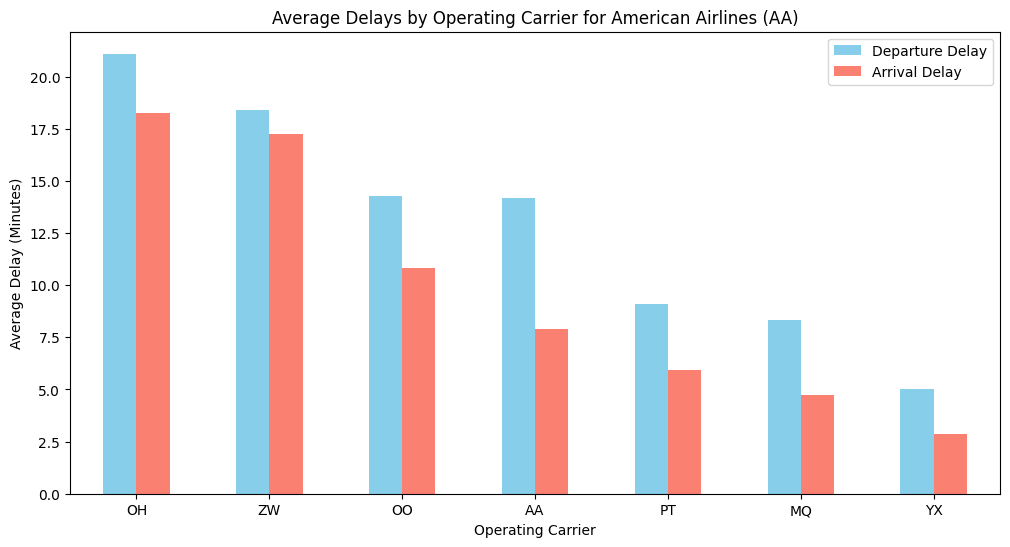

In [48]:
# Filter for American Airlines (AA) marketing flights
aa_collab_df = testing_df[testing_df['MKT_UNIQUE_CARRIER'] == 'AA']

# Calculate average Departure and Arrival delays by Operating Carrier
aa_avg_delays = aa_collab_df.groupby('OP_UNIQUE_CARRIER')[['DEP_DELAY', 'ARR_DELAY']].mean().sort_values(by='ARR_DELAY', ascending=False)

print("Average Delays for American Airlines (AA) Collaborations:")
display(aa_avg_delays)

# Visualization
plt.figure(figsize=(12, 6))
aa_avg_delays.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title('Average Delays by Operating Carrier for American Airlines (AA)')
plt.xlabel('Operating Carrier')
plt.ylabel('Average Delay (Minutes)')
plt.legend(['Departure Delay', 'Arrival Delay'])
plt.xticks(rotation=0)
plt.show()